In [1]:
import pandas as pd

%load_ext autoreload
%autoreload 2

## Перевод текстовых данных в векторную форму

Для этого я решил использовать библиотеку `transformers` от Hugging Face и модель BERT предобученную лабораторией DeepPavlov

In [1]:
from torch.utils.data import DataLoader
from utils.dataset import ProductDataset, collate_products

In [2]:
dataset = ProductDataset("data.csv")

data_dataloader = DataLoader(dataset, batch_size=32, collate_fn=collate_products)

In [4]:
from transformers import AutoTokenizer, AutoModel
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = model.cuda()

In [7]:
import torch
from tqdm import tqdm_notebook
vectors = []
model.eval()
for batch_tokens in tqdm_notebook(data_dataloader):
    out = model(**batch_tokens)
    out = torch.mean(out.last_hidden_state, dim=1)
    vectors.append(out.cpu().detach())
product_vectors = torch.cat(vectors)

<ipython-input-7-6656edac8b93>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_tokens in tqdm_notebook(data_dataloader):


  0%|          | 0/6250 [00:00<?, ?it/s]

In [8]:
product_vectors.shape

torch.Size([200000, 768])

In [9]:
import numpy as np
np.save("product_vectors.npy", product_vectors.numpy())

In [28]:
import numpy as np
import pandas as pd

In [30]:
product_vectors = np.load('product_vectors.npy')
df = pd.read_csv("data.csv", index_col=0)
df = df.reset_index(drop=True)

In [1]:
from utils.data_manipulation import create_products_vectors

In [3]:
create_products_vectors("data.csv", "product_vectors.npy")

100%|██████████| 6250/6250 [05:01<00:00, 20.74it/s]


NotADirectoryError: [Errno 20] Not a directory: 'product_vectors.npy/product_vectors.npy'

### Plot Dendogram

In [54]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [55]:
import random
from utils.data_manipulation import load_product_vectors
product_vectors = load_product_vectors("product_vectors.npy")
n_products = np.random.choice(range(len(product_vectors)), 5000)
# n_products=20000

In [56]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [57]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(product_vectors[n_products])

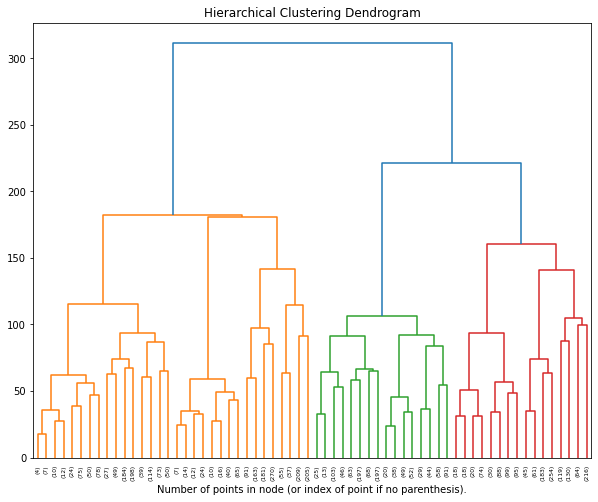

In [58]:
plt.figure(figsize=(10,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.savefig("dendogram.png")
plt.show()

## Dimensionality Reduction and Clustering
### PCA

In [99]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pandas as pd

df = pd.read_csv("data.csv", index_col=0)
df = df.reset_index(drop=True)
random_state = 0
sampled_vectors = np.random.choice(range(product_vectors.shape[0]), 10000)
# sampled_show=np.random.choice(range(sampled_vectors.shape[0]), 5000)
# sampled_show=sampled_vectors[sampled_show]
# sampled_vectors = list(range(20000))
sampled_show = list(range(5000))

pca = PCA(n_components=2)
project_vectors = pca.fit_transform(product_vectors[sampled_vectors])


In [100]:
import faiss
import numpy as np


class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X, y=None):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]

In [101]:
fkmeans = FaissKMeans(n_clusters=32)
fkmeans.fit(product_vectors[sampled_vectors])
labels = fkmeans.predict(product_vectors[sampled_vectors])

labels=labels.reshape(-1)

In [106]:
# kmeans = KMeans(n_clusters=32).fit(product_vectors[sampled_vectors])
# labels = kmeans.labels_

In [107]:
import plotly.express as px
fig=px.scatter(df.iloc[sampled_vectors[sampled_show]],
               x=project_vectors[sampled_show, 0],
               y=project_vectors[sampled_show, 1],
               hover_data=['title'],
               color = labels[sampled_show]
                 )
fig.show()

### t-SNE

In [108]:
tsne = TSNE(n_components=2, random_state=random_state, verbose=1, n_jobs=-1)
project_vectors = tsne.fit_transform(product_vectors[sampled_vectors])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.612s...
[t-SNE] Computed neighbors for 10000 samples in 38.738s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.310832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.609192
[t-SNE] KL divergence after 1000 iterations: 2.347653


In [109]:
fig=px.scatter(df.iloc[sampled_vectors[sampled_show]],
               x=project_vectors[sampled_show, 0],
               y=project_vectors[sampled_show, 1],
               hover_data=['title'],
               color = labels[sampled_show]
                 )
fig.show()

### UMAP

In [110]:
from umap.umap_ import UMAP

umap_2d = UMAP(n_components=2, init='random', random_state=0)

In [111]:
proj_2d = umap_2d.fit_transform(product_vectors[sampled_vectors])

In [112]:
fig_2d = px.scatter(df.iloc[sampled_vectors[sampled_show]],
    x=proj_2d[sampled_show,0],
    y=proj_2d[sampled_show,1],
    color=labels[sampled_show], hover_data=['title']
)
fig_2d.show()